In [31]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font = {'family': 'normal', 'weight': 'bold', 'size': '14'}

matplotlib.rc('font', **font)



''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def universal_func(So=2000, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    g = 13.7 #m/s^2 #gravity
    Pc = 6e4
    Po = 1.01e5
    R_star = 8.3145
    k3 = 0.08 # relates the strength of convection to the cloud fraction
    #fc = 0
    def equations(p): 
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2
        M = 0.018
        To = 273.15
        mass_ratio = M/mm_dry

        sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
        
        H = ((R_star/mm_dry)*T2)/g #scale height
        
        Tc = 230 #Cloud emission temp
        Z_a = np.log(Po/Pc)*H #convection height
        Cpd = 1005.7 #J/kgK #heat capacity
        Cpv = 1996 #J/kgK #heat capacity
        L = 2.501e6 # J/kg #latent heat of vaporization
        
        RH1 = 0.9 #Relative Humidity
        RH2 = 0.8 
        RH3 = 0.3
        
        
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        ws_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        w_1 = RH1 * ws_1
        q1 = w_1/(1+w_1)
        q1_s = ws_1/(1+ws_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        '''
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        w_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        q3_s = w_3/(1+w_3)

        q1 = RH1 * q1_s
        q2 = RH2 * q2_s #specific humidity
        q3 = RH3 * q3_s #specific humidity
        '''
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1
        Cp2 = Cpd*(1 - q2) + Cpv * q2
        
        ''' Want to add the greenhouse effect.epsilon and tau.'''
        
        #q1 = RH_1 * q1_s #Need to change this relation to the exact definition
        #q2 = RH_2 * q2_s #specific humidity
        #q3 = RH_3 * q3_s #specific humidity

        #So = 2000 # W/m^2 Solar insolation
        #Fo' = 0 # Ocean heat transport

        
        k1 = 0.2 # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity 
        #k3 = 0.08 # relates the strength of convection to the cloud fraction
        Fd = k1*Fa
        
        fc = k3*np.log(Fc+1.0)
        
        alpha_p = 0.09+fc - 0.09*fc # planetary albedo
        
        def Tv(T,mass_ratio,w):
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        def tau(T,Tft):
            tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
            return tau
            
        epsilon_2_tau = 1/(1+tau(T2,273))
        epsilon_3_tau = 1/(1+tau(T3,273))
        epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
        epsilon_3 = 1 - np.exp(-k2*q3)
        
        

        #Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2_tau*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4
        Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        #Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2_tau*sigma*T2**4 - 2*fc*sigma*Tc**4
        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        #Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3_tau*sigma*T3**4
        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3_tau*sigma*T3**4

        #Eq5 = Fo + Fd + epsilon_3_tau*sigma*T3**4 - sigma*T4**4
        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        #OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2_tau*sigma*T2**4
        #OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3_tau*sigma*T3**4
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux = epsilon_2*sigma*T2**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night,Flux)
        
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations,p_guess,full_output=True)
    if ier==1:
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    #fc_2 = fc
    fc_2 = k3*np.log(Fc+1.0)
    if fc_2 >=1:
        print('cloud fraction: ',fc_2)
    index=1
    #print('Solved.')
    q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux = equations((T1, T2, T3, T4, Fa, Fc))
    if debug==False:
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night)
    else:
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,info,ier,msg)

In [32]:
universal_func(So=2000, assumption='WBG',debug=True,\
    p_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153))

We have a solution:  (285.93372800130413, 262.4170601029449, 262.62729920413835, 247.42055654163389, 266.9261586179098, 315.8383414429571)


(285.93372800130413,
 262.4170601029449,
 262.62729920413835,
 247.42055654163389,
 266.9261586179098,
 315.8383414429571,
 0.46067133439192975,
 0.008546615276667748,
 0.0023339840007643485,
 0.0008911748275548481,
 0.5092109142966561,
 0.9030911081138381,
 0.5898264136548963,
 223.86292708962463,
 246.25405515830604,
 {'nfev': 43,
  'fjac': array([[-2.40163433e-03,  1.95395017e-03,  4.88328613e-03,
           1.92180690e-02, -1.83602475e-05,  9.99798596e-01],
         [-7.49349648e-02,  1.57225964e-01, -8.36268566e-01,
           5.14363474e-01, -7.55663326e-02, -6.29116659e-03],
         [-5.87063418e-02,  1.23103809e-01, -5.02206516e-01,
          -8.48158354e-01,  9.73516854e-02,  1.83763424e-02],
         [ 1.92320179e-01, -4.03467135e-01, -1.13420877e-01,
           9.65293482e-02,  8.82068596e-01, -3.48156688e-05],
         [-2.11470298e-01, -8.87806742e-01, -1.54550140e-01,
          -6.54182398e-02, -3.72697949e-01,  3.23258884e-03],
         [-9.53533330e-01,  9.55776714e-02

In [33]:
sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
so = np.linspace(1000,4500,100)
nele = len(so)
T1_arr_WBG, T2_arr_WBG, T3_arr_WBG, T4_arr_WBG, Fa_arr_WBG, Fc_arr_WBG, fc_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG, OLR_day_arr_WBG, OLR_night_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

initial_guess = (250,250,200,200,200,20)
for idx,s in enumerate(so):
    print(idx,s)
    T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx], fc_arr_WBG[idx], \
        q1_arr_WBG[idx],q2_arr_WBG[idx],q3_arr_WBG[idx],alpha_p_arr_WBG[idx],epsilon_2_arr_WBG[idx],epsilon_3_arr_WBG[idx], \
        OLR_day_arr_WBG[idx], OLR_night_arr_WBG[idx], info,ier,msg = universal_func(So = s, assumption  = 'WBG',p_guess=initial_guess,debug=True)
    #if ier!=1:
    #    print(ier,msg)
    #    T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx], fc_arr_WBG[idx], \
    #        q1_arr_WBG[idx],q2_arr_WBG[idx],q3_arr_WBG[idx],alpha_p_arr_WBG[idx],epsilon_2_arr_WBG[idx],epsilon_3_arr_WBG[idx], \
    #        OLR_day_arr_WBG[idx], OLR_night_arr_WBG[idx], info,ier,msg = universal_func(So = s, assumption  = 'WBG',debug=True)
    #    if ier!=1: print('Cannot find a solution...')
    initial_guess = (T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx])
    #print('end of loop ',initial_guess)
LR_atm_WBG = epsilon_2_arr_WBG*sigma*(T2_arr_WBG**4)

0 1000.0
We have a solution:  (219.53431988337783, 190.34121807108687, 190.34128032403856, 143.25290413513213, 119.25826281055623, 197.86866967094457)
1 1035.3535353535353
We have a solution:  (221.92376125726142, 192.43191250851405, 192.4319982365194, 144.839562949551, 124.5806205469334, 200.94832170772509)
2 1070.7070707070707
We have a solution:  (224.23242521486478, 194.4569943806059, 194.4571105050411, 146.38084683378142, 129.90239611186723, 204.01695871176202)
3 1106.060606060606
We have a solution:  (226.46567825449486, 196.42175529962358, 196.42191026881358, 147.88161230772172, 135.22497677518479, 207.0775636873047)
4 1141.4141414141413
We have a solution:  (228.6282849453069, 198.33100438258396, 198.3312084099529, 149.34648574575016, 140.54990962550457, 210.13333958619597)
5 1176.7676767676767
We have a solution:  (230.7245001121562, 200.18914455398513, 200.18940988275256, 150.77993402663145, 145.87890890500591, 213.18772474032875)
6 1212.121212121212
We have a solution:  (232

<ipython-input-31-62edc7c57bdc>:114: RuntimeWarning: overflow encountered in exp
  epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
<ipython-input-31-62edc7c57bdc>:123: RuntimeWarning: invalid value encountered in double_scalars
  Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4
<ipython-input-31-62edc7c57bdc>:140: RuntimeWarning: invalid value encountered in double_scalars
  OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4


In [34]:
nele = len(so)
T1_arr_WTG, T2_arr_WTG, T3_arr_WTG, T4_arr_WTG, Fa_arr_WTG, Fc_arr_WTG, fc_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG, OLR_day_arr_WTG, OLR_night_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

initial_guess = (250,250,200,200,200,20)
for idx,s in enumerate(so):
    print(idx,s)
    T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx], fc_arr_WTG[idx], \
        q1_arr_WTG[idx],q2_arr_WTG[idx],q3_arr_WTG[idx],alpha_p_arr_WTG[idx],epsilon_2_arr_WTG[idx],epsilon_3_arr_WTG[idx], \
        OLR_day_arr_WTG[idx], OLR_night_arr_WTG[idx],info,ier,msg = universal_func(So = s, assumption  = 'WTG',debug=True,p_guess=initial_guess)
    #if ier!=1: print(ier,msg)
    initial_guess = (T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx])
LR_atm_WTG = epsilon_2_arr_WTG*sigma*(T2_arr_WTG**4)

0 1000.0
We have a solution:  (219.5366201755492, 190.3403916678572, 190.3403916678572, 143.2522273709436, 119.25603720581267, 197.86373263528927)
1 1035.3535353535353
We have a solution:  (221.92679142620602, 192.43083223776577, 192.43083223776577, 144.83867688888427, 124.57760389764195, 200.9416284467058)
2 1070.7070707070707
We have a solution:  (224.23635680669585, 194.45560364031087, 194.45560364031087, 146.379698060366, 129.89837461112674, 204.0080317992948)
3 1106.060606060606
We have a solution:  (226.4707091029266, 196.4199897854649, 196.4199897854649, 147.8801423405997, 135.21969680552473, 207.06583465486878)
4 1141.4141414141413
We have a solution:  (228.63464068272313, 198.3287919335848, 198.3287919335848, 149.34462701480373, 140.5430741412384, 210.11813940872963)
5 1176.7676767676767
We have a solution:  (230.73243539982877, 200.18640515908547, 200.18640515908547, 150.7776089468096, 145.87017417999306, 213.16827453072506)
6 1212.121212121212
We have a solution:  (232.76794

<ipython-input-31-62edc7c57bdc>:114: RuntimeWarning: overflow encountered in exp
  epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
<ipython-input-31-62edc7c57bdc>:123: RuntimeWarning: invalid value encountered in double_scalars
  Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4
<ipython-input-31-62edc7c57bdc>:140: RuntimeWarning: invalid value encountered in double_scalars
  OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4


(4, 100)


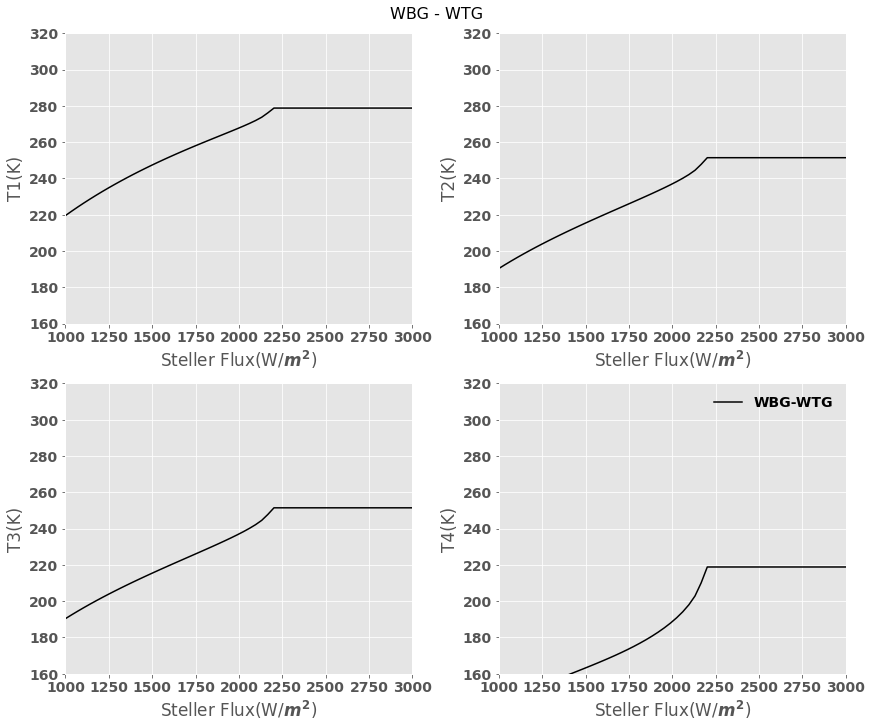

In [35]:

def plot_diff(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    plt.suptitle('WBG - WTG', fontsize = 16)
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    #arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    #arr_list = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    #arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(4) ]

    nele = len(arr_list)
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    name_list = ['T1','T2','T3','T4']
    unit_list = ['K','K','K','K']
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '','']
    
    if nele % 2 == 0:
        nrows = (nele)//2
    else:
        nrows = (nele)//2+1, 
    ncols = 2
    print(np.shape(arr_list))

    for idx, arr in enumerate(arr_list):
        ax  =plt.subplot(nrows, ncols, idx + 1)

        ax.plot(so, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        ax.set_xlabel(xlab +'('+ xunit +')')
        ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        plt.xlim(1000,3000)
        plt.ylim(160,320)
        if idx ==3: 
            plt.legend(frameon = False)
    #plt.savefig("WTG_WBG_diff_T1-T4.png")
    plt.close()

    return fig
plot_diff(so)

(6, 100)


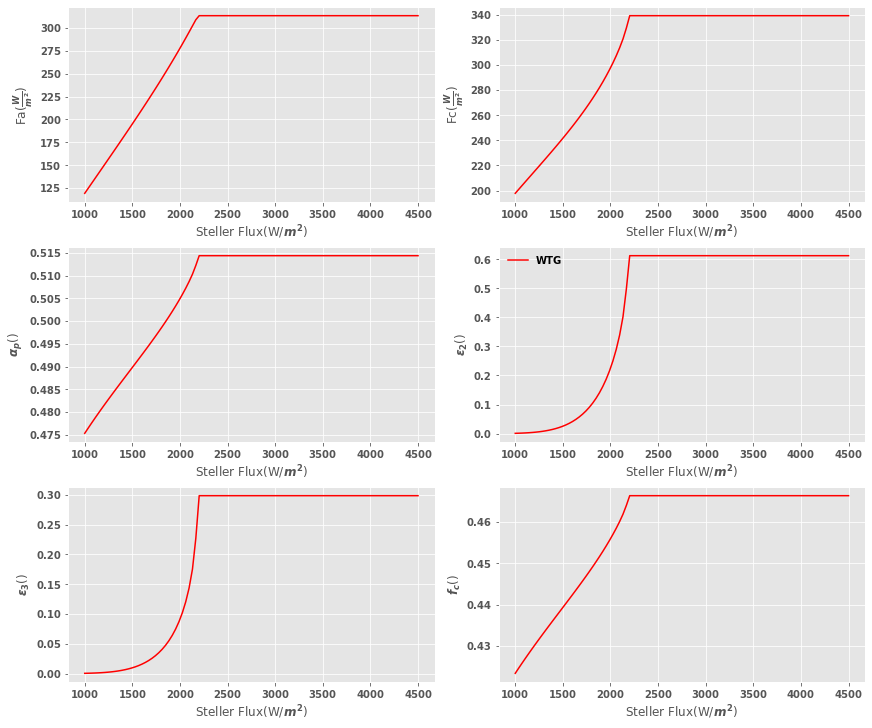

In [36]:
def plot_across_so(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    plt.style.use('ggplot')

    for i_assump, (assumption, my_color) in enumerate(zip(['WTG'], ['r'])):
        if assumption == 'WBG':
            #arr_list = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
            #arr_list = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
            arr_list = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG,fc_arr_WBG ]
            #arr_list = [T2_arr_WBG, epsilon_2_arr_WBG,OLR_day_arr_WBG,LR_atm_WBG]
            #arr_list = [T1_arr_WBG,T4_arr_WBG,OLR_day_arr_WBG,OLR_night_arr_WBG]
            
        elif assumption == 'WTG':
            #arr_list = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
            #arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
            arr_list = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG,fc_arr_WTG]
            #arr_list = [T2_arr_WTG, epsilon_2_arr_WTG,OLR_day_arr_WTG,LR_atm_WTG]
            #arr_list = [T1_arr_WTG,T4_arr_WTG,OLR_day_arr_WTG,OLR_night_arr_WTG]
        
        nele = len(arr_list)
        #name_list = ['T1','T2','T3','T4']
        #unit_list = ['K','K','K','K']
        #name_list = ['q1','q2','q3','fc']
        #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
        name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
        unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '','']
        #name_list = ['T1','T4', 'OLR Dayside', 'OLR Nightside']
        #unit_list = ['K', 'K', r'$\frac{W}{m^2}$', r'$\frac{W}{m^2}$']
        
        
        if nele % 2 == 0:
            nrows = (nele)//2
        else:
            nrows = (nele)//2+1
        ncols = 2
        print(np.shape(arr_list))
        ax = plt.axes(facecolor='#E6E6E6')
        ax.set_axisbelow(True)

        for idx, arr in enumerate(arr_list):
            ax  = plt.subplot(nrows, ncols, idx + 1)

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption)


            #ax.set_title(assumption)
            ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            #plt.xlim(1000,3000)
            #plt.ylim(160,320)
            if idx ==3: 
                plt.legend(frameon = False)
    #plt.savefig("WTG_WBG_compare_T1-T4.png")
    plt.close()

    return fig

plt.rcParams['figure.constrained_layout.use']=True
plot_across_so(so)

### plotting

(4, 100)
(4, 100)


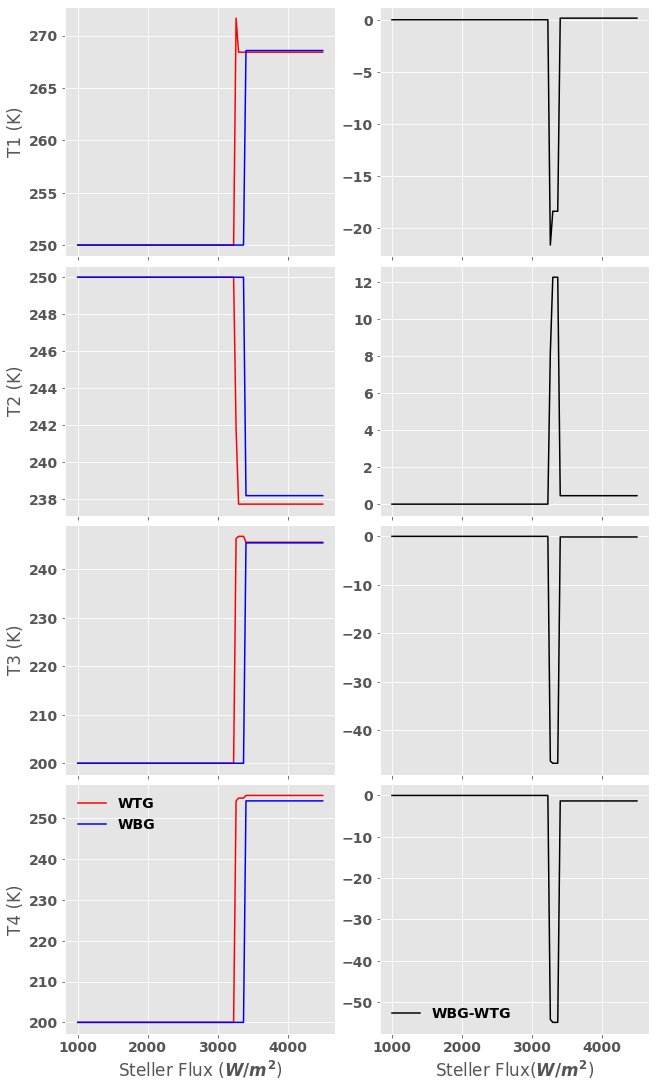

In [24]:
def plot_8panels(so, xlab = 'Steller Flux', xunit = '$W/m^2$'): 
   
    
    
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    #arr_list_WTG = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    #arr_list_WTG = [OLR_day_arr_WTG, OLR_night_arr_WTG]
    #arr_list_WBG  = [OLR_day_arr_WBG, OLR_night_arr_WBG]
    #arr_list_WBG = [T1_arr_WBG,]
    
    
    name_list = ['T1','T2','T3','T4']
    unit_list = ['K','K','K','K']
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '']
    #unit_list = [r'$W/m^2$',r'$W/m^2$','','', '']
    #name_list = ['OLR_day', 'OLR_night']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$']
    
    nele = len(name_list)
    ncols = 2
    nrows = nele
    fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (9,15))
    ax = axs[0][0]
    
    #nele = len(arr_list)
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']
    
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            arr_list = arr_list_WBG
        elif assumption == 'WTG':
            arr_list = arr_list_WTG
        
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax = axs[idx][0]

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            #ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+' ('+unit_list[idx]+')')
            #plt.xlim(1000,3000)
            #plt.ylim(50,350)
            if idx == nele - 1: 
                ax.legend(frameon = False)
                ax.set_xlabel(xlab +' ('+ xunit +')')
    
    
    ### plot difference
    #plt.suptitle('WBG - WTG', fontsize = 16)

    
    arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(nele) ]

    for idx, arr in enumerate(arr_list):
        ax = axs[idx][1]
        ax.plot(so, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        
        #ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        #plt.xlim(1000,3000)
        #plt.ylim(50,350)
        if idx == nele -1: 
            plt.legend(frameon = False)
            plt.xlabel(xlab +'('+ xunit +')')
            
    #axs[0][0].set_ylim(50,350)
    plt.savefig("WTG_WBG_q1-q3.png")
    plt.close()
    
    #fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
        
        
    

    return fig

font = {'family': 'normal', 'weight': 'bold', 'size': '14'}

matplotlib.rc('font', **font)
plt.rcParams['figure.constrained_layout.use']=True
plot_8panels(so)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


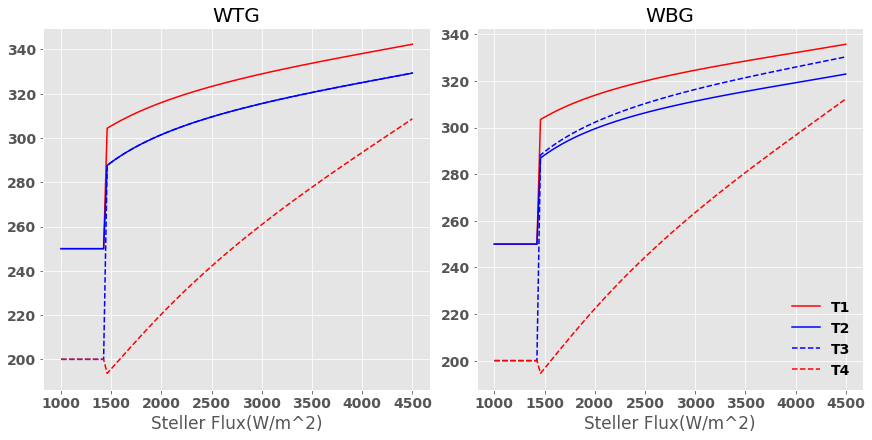

In [8]:
fig = plt.figure(figsize =(12,6))
plt.rcParams['savefig.facecolor']='white'

for i_assumption, assumption in enumerate(['WTG','WBG']): 
    ax = plt.subplot(1,2,1+i_assumption)
    ax.set_title(assumption)
    
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    
    if assumption == 'WBG':
        arr_list = arr_list_WBG
        epsilon_arr = epsilon_2_arr_WBG
    elif assumption == 'WTG': 
        arr_list = arr_list_WTG
        epsilon_arr = epsilon_2_arr_WTG
    
    ax.plot(so, arr_list[0], color = 'r', linestyle = '-', label = 'T1')
    ax.plot(so, arr_list[1], color = 'b', linestyle = '-', label = 'T2')
    ax.plot(so, arr_list[2], color = 'b', linestyle = '--', label = 'T3')
    ax.plot(so, arr_list[3], color = 'r', linestyle = '--', label = 'T4')
    
    #transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    #print(transition_point)
    #ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k')
    
    #transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    #print(transition_point)
    #ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k', label = r'$\epsilon_2 = 1$')
    if i_assumption == 1:
        ax.legend(frameon = False)
    plt.xlabel('Steller Flux' +'(W/m^2)')
    #plt.xlim(1000,3000)
    plt.savefig('WTG_WBG_eps2.png', facecolor=fig.get_facecolor(), transparent=False)


Text(0, 0.5, '$\\epsilon \\sigma T^4$')

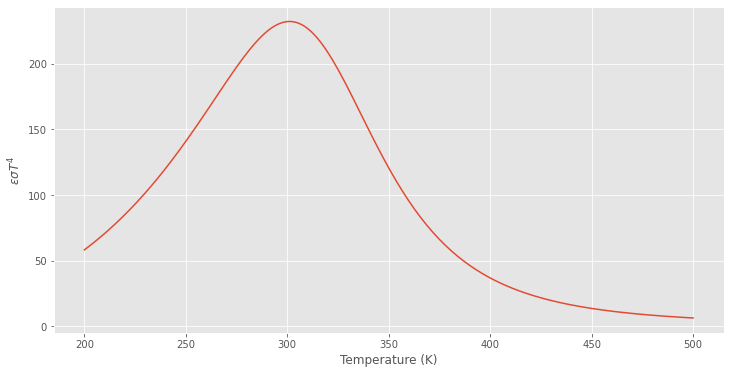

In [52]:

def tau(T,Tft):
    tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
    return tau
            
T = np.linspace(200,500,200)
epsilon_2 = 1/(1+tau(T,273))

Lr_atm = epsilon_2*sigma*T**4

fig = plt.figure(figsize =(12,6))
plt.style.use('ggplot')
plt.plot(T, Lr_atm)
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\epsilon \sigma T^4$')